1. Bajar esta carpeta: https://github.com/AlexeyAB/darknet

2. En esta carpeta esta el modelo base, sin los weights. Dentro de este github explica como bajar los weights

3. Adicionalmente, hay que instalar OpenCV para python  
pip install opencv-python

4. Bajar la notebook en la misma carpeta darknet del paso 1

5. Cargar imagenes y videos

6. correr la notebook y va a generar video nuevo con el mismo nombre original más '_output'

In [ ]:
import numpy as np
import cv2 as cv
import time
import matplotlib.pyplot as plt

In [ ]:
# Variables globales
flags_config = 'cfg\yolov4.cfg'
flags_labels = 'cfg\coco.names'
flags_weights = 'yolov4.weights'
flags_video_path = 'Driving-Chinatown-SF1.mp4'
flags_video_output = flags_video_path[:-4] + '_' + 'output.mp4'
flags_confidence = 0.5
flags_threshold = 0.3
flags_frames_stride = 4

In [ ]:
# dibuja labels y cajas

def draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels):
    
    ''' Dibuja las cajas en una imagen dada
    
    Parameters
    ----------
    img: numpy shape: height x width x channels
        Imagen a procesar con el modelo
    boxes: list
        Contiene todas las cajas detectadas en una imagen
    confidences: list
        Lista del valor de confianza de cada caja
    classids: list
        Lista de la clase de cada caja
    idxs: numpy
        Lista del indice valido de cada caja
    colors: numpy shape: len(label) x 3
        Colores random para las cajas
    labels: list
        Etiquetas para cada una de las clases de boxes
    
    Returns
    -------
    img: numpy shape: height x width x channels
        Imagen a procesar con el modelo
    
    '''
    
    # If there are any detections
    if len(idxs) > 0:
        for i in idxs.flatten():
            # Get the bounding box coordinates
            x, y = boxes[i][0], boxes[i][1]
            w, h = boxes[i][2], boxes[i][3]

            # Get the unique color for this class
            color = [int(c) for c in colors[classids[i]]]

            # Draw the bounding box rectangle and label on the image
            cv.rectangle(img, (x, y), (x+w, y+h), color, 2)
            text = "{}: {:4f}".format(labels[classids[i]], confidences[i])
            cv.putText(img, text, (x, y-5), cv.FONT_HERSHEY_SIMPLEX, 0.5, color, 2)

    return img


# genera las cajas

def generate_boxes_confidences_classids(outs, height, width, tconf):
    
    '''Define, para cada detección de cada output, cual es la clase detectada, el tamaño de la caja, y el nivel de probabilidad
    
    Parameters
    ----------
    outs: List (contiene cada una de las salidas de yolovx, cada elemento es un numpy shape: tamaño del output x (5 + clases))
        Son las detecciones que hizo cada capa de yolovx
    height: int
        Altura de la imagen
    width: int
        Ancho de la imagen
    tconf: float
        Nivel de confianza, sobre el cual considera correcta la clase detectada
    
    Returns
    -------
    boxes: list
        Contiene todas las cajas detectadas en una imagen
    confidences: list
        Lista del valor de confianza de cada caja
    classids: list
        Lista de la clase de cada caja
    
    
    '''
    
    boxes = []
    confidences = []
    classids = []

    for out in outs:
        for detection in out:
            
            # Definir si objectness score es mayor a confidence
            if detection[4] > tconf:
            
                #print (detection)
                #a = input('GO!')

                # Get the scores, classid, and the confidence of the prediction
                scores = detection[5:]
                classid = np.argmax(scores)
                confidence = scores[classid]

                # Consider only the predictions that are above a certain confidence level
                if confidence > tconf:
                    # TODO Check detection
                    box = detection[0:4] * np.array([width, height, width, height])
                    centerX, centerY, bwidth, bheight = box.astype('int')

                    # Using the center x, y coordinates to derive the top
                    # and the left corner of the bounding box
                    x = int(centerX - (bwidth / 2))
                    y = int(centerY - (bheight / 2))

                    # Append to list
                    boxes.append([x, y, int(bwidth), int(bheight)])
                    confidences.append(float(confidence))
                    classids.append(classid)

    return boxes, confidences, classids


# Arma la imagen con las cajas

def infer_image(net, layer_names, height, width, img, colors, labels, flags_confidence, flags_threshold,
            boxes=None, confidences=None, classids=None, idxs=None, infer=True):

    ''' Procesa cada imagen solicitada
    
    Parameters
    ----------
    net: model
        El modelo de yolovx entrenado que se va a ejecutar
    layer_names: layers
        Los layers de Yolo que generan outputs
    height: int
        Altura del frame
    width: int
        Ancho del frame
    img: numpy shape: height x width x channels
        Imagen a procesar con el modelo
    colors: numpy shape: len(label) x 3
        Colores random para las cajas
    labels: list
        Etiquetas para cada una de las clases de boxes
    flags_confidence: float
        Valor a partir del cual se van a considerar validas las clases
    flags_threshold: float
        Valor minimo para non max suppression
    boxes: list
        Contiene todas las cajas detectadas en una imagen
    confidences: list
        Lista del valor de confianza de cada caja
    classids: list
        Lista de la clase de cada caja
    idxs: numpy
        Lista del indice valido de cada caja
    infer: bool
        Define si tiene que buscar cajas en una imagen (True), o solo agregar cajas con los datos enviados en los parametros
    
    Returns
    -------
    img: numpy shape: height x width x channels
        Tiene la imagen original, a la que se le agregaron las cajas resultantes del proceso de la imagen
    boxes: list
        Contiene todas las cajas detectadas en una imagen
    confidences: list
        Lista de los valores de confianza de cada caja
    classids: list
        Lista de las clases de cada caja
    idxs: list
        Lista de los indices validos de cada caja
    
    '''
    
    if infer:
        # Contructing a blob from the input image
        blob = cv.dnn.blobFromImage(img, 1 / 255.0, (416, 416),
                        swapRB=True, crop=False)

        # Perform a forward pass of the YOLO object detector
        net.setInput(blob)

        # Getting the outputs from the output layers
        outs = net.forward(layer_names)

        # Generate the boxes, confidences, and classIDs
        boxes, confidences, classids = generate_boxes_confidences_classids(outs, height, width, flags_confidence)

        # Apply Non-Maxima Suppression to suppress overlapping bounding boxes
        idxs = cv.dnn.NMSBoxes(boxes, confidences, flags_confidence, flags_threshold)

    if boxes is None or confidences is None or idxs is None or classids is None:
        raise '[ERROR] Required variables are set to None before drawing boxes on images.'

    # Draw labels and boxes on the image
    img = draw_labels_and_boxes(img, boxes, confidences, classids, idxs, colors, labels)

    return img, boxes, confidences, classids, idxs

In [ ]:
# Get the labels
labels = open(flags_labels).read().strip().split('\n')
print(labels)

['person', 'bicycle', 'car', 'motorbike', 'aeroplane', 'bus', 'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'stop sign', 'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow', 'elephant', 'bear', 'zebra', 'giraffe', 'backpack', 'umbrella', 'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball', 'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket', 'bottle', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl', 'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza', 'donut', 'cake', 'chair', 'sofa', 'pottedplant', 'bed', 'diningtable', 'toilet', 'tvmonitor', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone', 'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'book', 'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush']


In [ ]:
# Intializing colors to represent each label uniquely
colors = np.random.randint(0, 255, size=(len(labels), 3), dtype='uint8')

In [ ]:
# Load the weights and configutation to form the pretrained YOLOvx model
net = cv.dnn.readNetFromDarknet(flags_config, flags_weights)

In [ ]:
# Get the output layer names of the model
layer_names = net.getLayerNames()
layer_names = [layer_names[i[0] - 1] for i in net.getUnconnectedOutLayers()]

In [ ]:
layer_names

['yolo_139', 'yolo_150', 'yolo_161']

In [ ]:
net.getUnconnectedOutLayers()

array([[327],
       [353],
       [379]], dtype=int32)

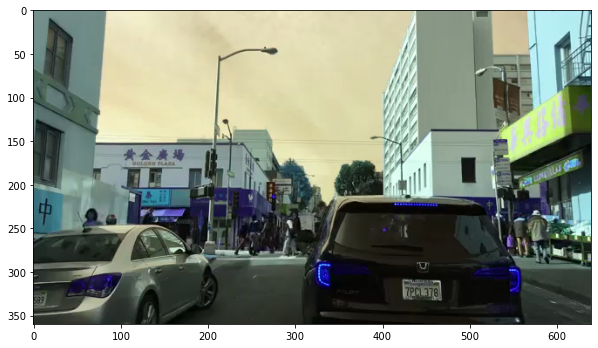

In [ ]:
# capturar un frame de un video
vid = cv.VideoCapture(flags_video_path)
grabbed, frame = vid.read()

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()

In [ ]:
# obtener  un blob (es una imagen en el formato requerido por yolo)
blob = cv.dnn.blobFromImage(frame, 1 / 255.0, (416, 416),
                        swapRB=True, crop=False)

# Perform a forward pass of the YOLO object detector
net.setInput(blob)

# Getting the outputs from the output layers
outs = net.forward(layer_names)

# mostrar los shapes de cada salida
[out.shape for out in outs]

[(8112, 85), (2028, 85), (507, 85)]

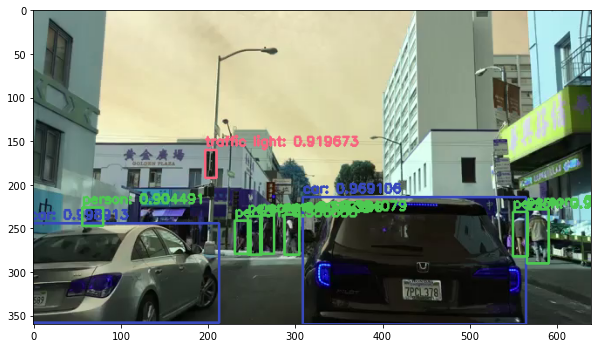

In [ ]:
# Ejecutar yolo v4
height, width = frame.shape[:2]
frame, _, _, _, _ = infer_image(net, layer_names, height, width, frame, colors, labels, flags_confidence, flags_threshold)

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()

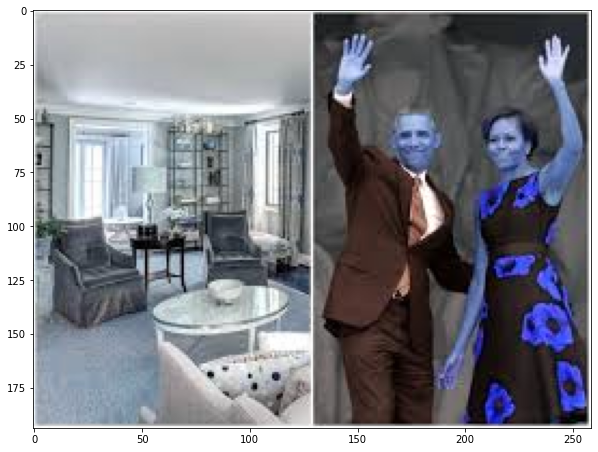

In [ ]:
# Ejemplo de imagen
frame = cv.imread('inside.jpg')

# Mostrar imagen
plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()

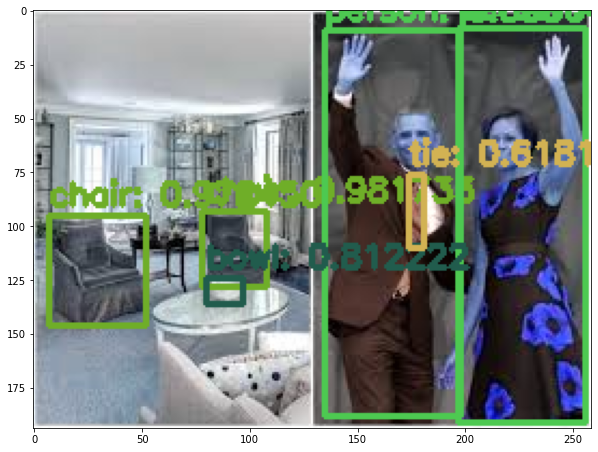

In [ ]:
# Ejecutar yolo v4
height, width = frame.shape[:2]
frame, _, _, _, _ = infer_image(net, layer_names, height, width, frame, colors, labels, flags_confidence, flags_threshold)

# Mostrar resultado
plt.figure(figsize=(10, 10))
plt.imshow(frame)
plt.show()

In [ ]:

# Validar que haya un video para recorrer
if flags_video_path is None:
    print ('Path to video not provided')

elif flags_video_path:
    
    # Read the video
    vid = cv.VideoCapture(str(flags_video_path))
    
    # obtener total de frames para mostrar porcentaje de avance
    img_total = int(vid.get(cv.CAP_PROP_FRAME_COUNT))
    img_total /= flags_frames_stride 
    
    # Inicializar variables 
    height, width, writer= None, None, None
    
    # inicializar cantidad de imagenes procesadas
    img_procesadas = 0
    
    # marcar tiempo de inicio
    inicio = time.time()
    
    while True:
        
        # Capturar un frame               
        grabbed, frame = vid.read()

        if not grabbed:
            break
        
        # sumar uno y mostrar avance de a 20
        img_procesadas += 1
        if img_procesadas%int((100/flags_frames_stride)) == 0:
            porcentaje_avance = (img_procesadas / img_total) * 100
            print(f'Procesadas {img_procesadas} imagenes...')
            print(f'Avance {porcentaje_avance:3.2f}%')
            tiempo_transcurrido = (time.time() - inicio)
            tiempo_transcurrido_f = time.strftime("%H:%M:%S",time.gmtime(tiempo_transcurrido))
            print(f'Tiempo transcurrido: {tiempo_transcurrido_f}\n')
        
        # obtener ancho y alto de la imagen recuperada (por primera vez)
        if width is None or height is None:
            height, width = frame.shape[:2]
        
        # procesar imagen
        frame, _, _, _, _ = infer_image(net, layer_names, height, width, frame, colors, labels, flags_confidence, flags_threshold)
        
        # grabar el frame en un nuevo video
        if writer is None:
            fourcc = cv.VideoWriter_fourcc(*'mp4v')
            writer = cv.VideoWriter(flags_video_output, fourcc, 30,(frame.shape[1], frame.shape[0]), True)

        writer.write(frame)
        
        # saltear 10 frames
        
        # Capturar un frame               
        saltear = 1
        while saltear < flags_frames_stride and grabbed:
            grabbed, frame = vid.read()
            saltear +=1

        if not grabbed:
            break
        

    # mostrar estadisticas finales
    print(f'Procesadas {img_procesadas} imagenes en total')
    tiempo_transcurrido = (time.time() - inicio)
    tiempo_transcurrido_f = time.strftime("%H:%M:%S",time.gmtime(tiempo_transcurrido))
    print(f'Tiempo Total: {tiempo_transcurrido_f}\n')
    
    # liberar video de input y de output
    print ("[INFO] Cleaning up...")
    writer.release()
    vid.release()


else:
    print("[ERROR] Something's not right...")

Procesadas 25 imagenes...
Avance 26.11%
Tiempo transcurrido: 00:00:08

Procesadas 50 imagenes...
Avance 52.22%
Tiempo transcurrido: 00:00:17

Procesadas 75 imagenes...
Avance 78.33%
Tiempo transcurrido: 00:00:26

Procesadas 96 imagenes en total
Tiempo Total: 00:00:34

[INFO] Cleaning up...
